<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/10_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Paper Replicating

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version son olarak 1.12+ ve üstü olmalıdır."
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version 0.13+ üstü olmalıdır."
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision verisonlarını güncel hale getirmeliyiz!")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Torchinfo yoksa indirilecek.
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulanamadı. İndiriliyor.")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlı dosyalar
    print("[INFO] Github dosyaları indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ı
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
[INFO] Torchinfo bulanamadı. İndiriliyor.
[INFO] Github dosyaları indiriliyor.
Cloning into 'PyTorch_Education'...
remote: Enumerating objects: 547, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 547 (delta 22), reused 3 (delta 3), pack-reused 503 (from 2)
Receiving objects: 100% (547/547), 63.15 MiB | 27.81 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Updating files: 100% (334/334), done.
data/pizza_steak_sushi Dosyası olusturuluyor
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Aşama-2: Veri Alma

[INFO] data/pizza_steak_sushi directory exists, skipping download.
Transforma boyutu 224'ten oluşturuldu: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


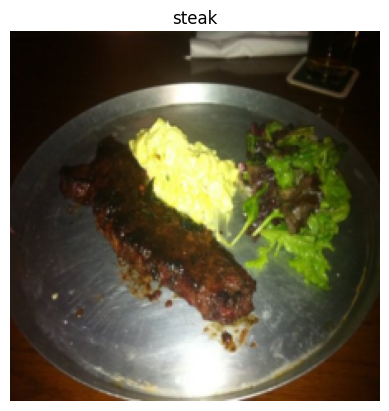

In [3]:
#GitHub MrDbourke içeriğini indiriyoruz.
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
#Train ve Test veri yollarını oluşturuyoruz.
train_dir = image_path / "train"
test_dir = image_path / "test"

#ViT için yükseklik ve genişliği 224x224=4096 haline getirmeliyiz.
IMG_SIZE = 224

# Elle Transform'u oluşturalım.
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Transforma boyutu 224'ten oluşturuldu: {manual_transforms}")

# Batch Miktarı
BATCH_SIZE = 32 #Normalde 4096 olmalı ama yüksek bir sistemimiz yok. Dolayısıyla 32'de kalacağız.

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Yukarıda oluşturduğumuz transform ile devam edeiyoruz.
    batch_size=BATCH_SIZE
)

# GÖRSELLEŞTİRME YAPALIM
# Resimlerin batch'te olanlarını alalım.
image_batch, label_batch = next(iter(train_dataloader))

# Batch'ten bir resim alalım.
image, label = image_batch[0], label_batch[0]

# Görselleştirelim.
plt.imshow(image.permute(1, 2, 0)) #  [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

##Aşama-3: Verileri Bölme Sınıf, Konum ve Patch Ayarlama

In [4]:
# Örnek bir Veri Oluşturalım.
height = 224 # H
width = 224 # W
color_channels = 3 # C -> Renk kanalları
patch_size = 16 # P

# Patch sayısını oluşturma
number_of_patches = int((height * width) / patch_size**2)
print(f"Patch Sayısı (N) with Resim Yüksekliği (H={height}), Genişliği (W={width}) ve Patch Miktarı (P={patch_size}): {number_of_patches}")

Patch Sayısı (N) with Resim Yüksekliği (H=224), Genişliği (W=224) ve Patch Miktarı (P=16): 196


In [5]:
# Girdi biçimi (Input Shape) -> H, W, C
embedding_layer_input_shape = (height, width, color_channels)

# Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Girdi biçimi (Input Shape) -> H, W, C: {embedding_layer_input_shape}")
print(f"Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: {embedding_layer_output_shape}")

Girdi biçimi (Input Shape) -> H, W, C: (224, 224, 3)
Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: (196, 768)


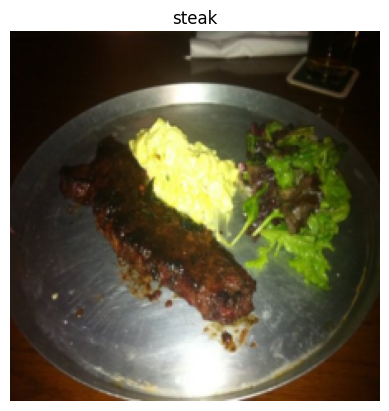

In [6]:
# Resmi Görüntüleme
plt.imshow(image.permute(1, 2, 0)) #Output Shape
plt.title(class_names[label])
plt.axis(False);

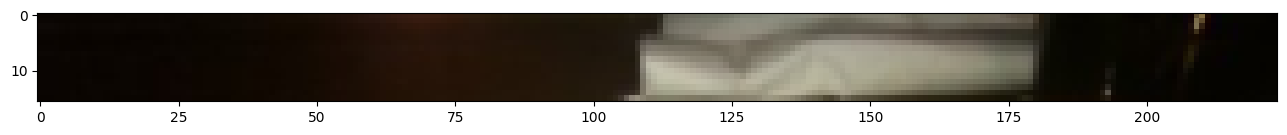

In [7]:
#(color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Patch miktarı belirtelim ve pikselleri görelim.
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Her Satırdaki patch sayısı: 14.0
Patch boyutu: 16 pixel x 16 pixel


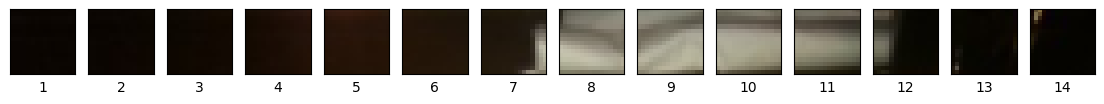

In [8]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Her Satırdaki patch sayısı: {num_patches}\nPatch boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # bir sütundaki her bir patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Resimleri etiketleri ile yan yana görüntüleyelim.
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # Yükseklik ve genişlik yan yana
    axs[i].set_xlabel(i+1) # Etiket
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Satırdaki Patch Sayısı: 14.0        
Sütundaki Patch Sayısı: 14.0        
Toplam Patch Sayısı: 196.0        
Patch Boyutu: 16 pixel x 16 pixel


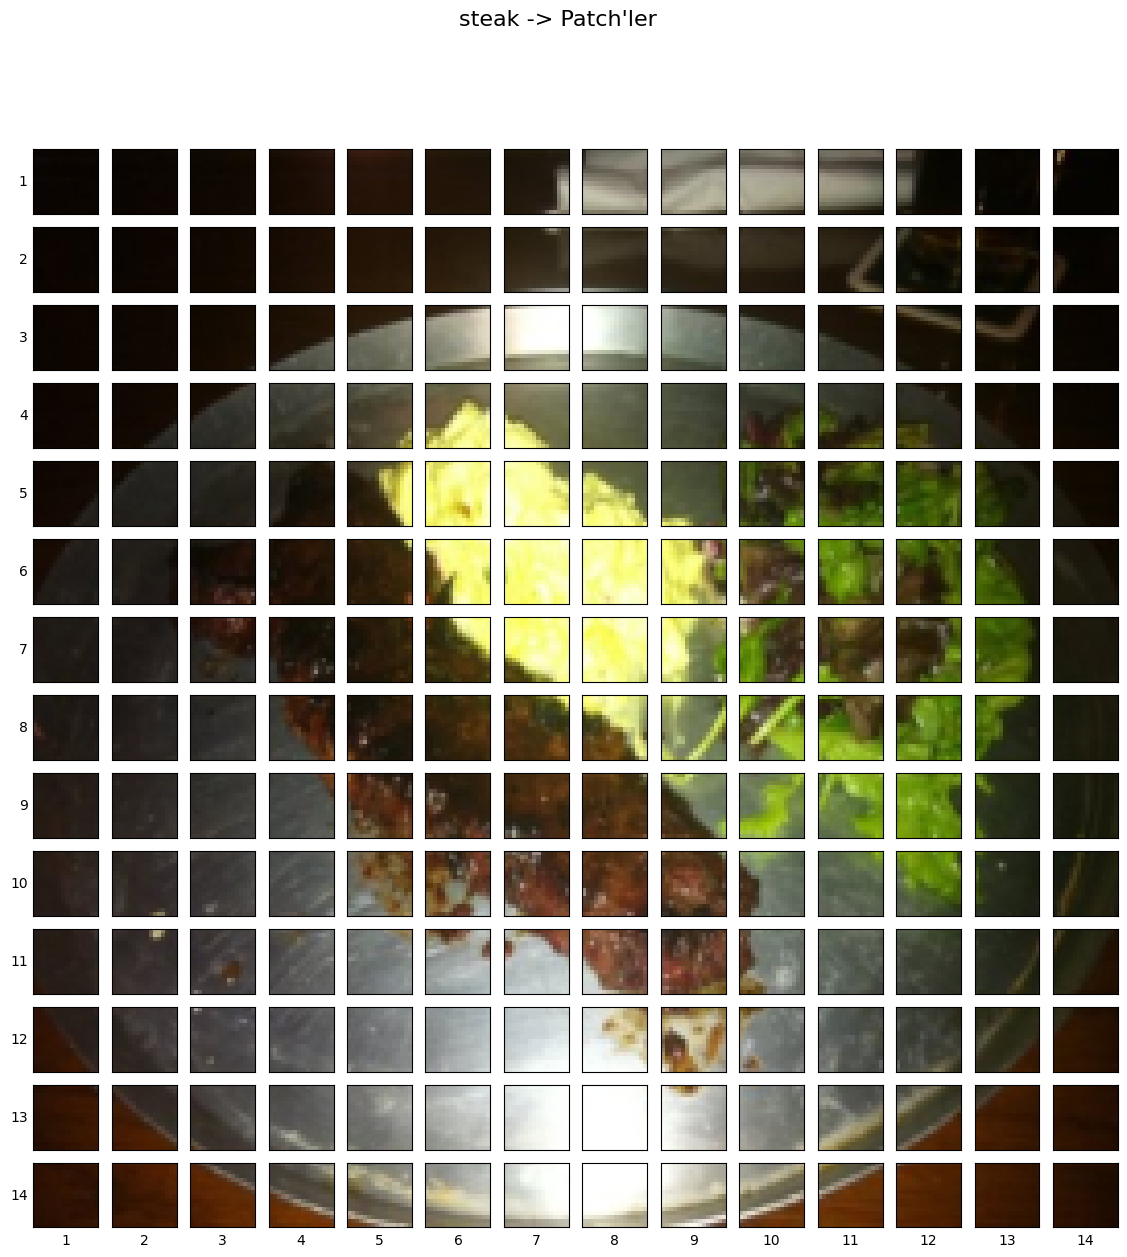

In [9]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Satırdaki Patch Sayısı: {num_patches}\
        \nSütundaki Patch Sayısı: {num_patches}\
        \nToplam Patch Sayısı: {num_patches*num_patches}\
        \nPatch Boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=img_size // patch_size, # int değerinde olmalı, float olamaz!
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Döngüler halinde her bir patch'i resmin yükseklik ve genişliğine oranla yerleştirelim.
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # image_permuted -> (Height, Width, Color Channels)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        # Etiketleri yazdırma
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Grafiğe Ana Başlık
fig.suptitle(f"{class_names[label]} -> Patch'ler", fontsize=16)
plt.show()

5 Evrimsel Boyut: [541, 468, 518, 164, 303]


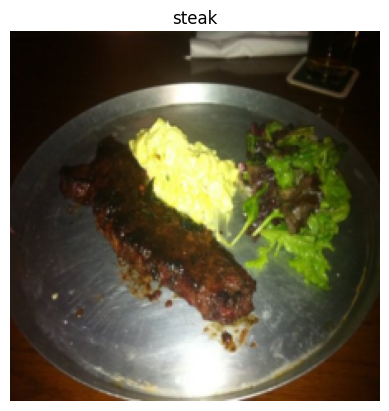

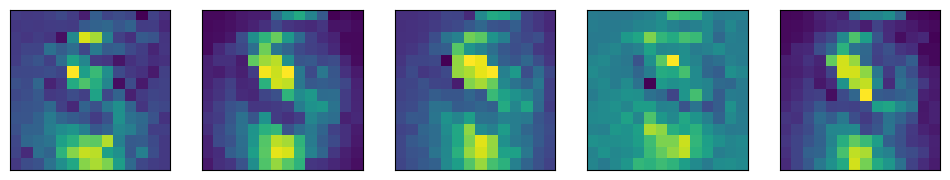

In [11]:
from torch import nn

# Patch Miktarı
patch_size=16

# Conv2d katmanı fakat ViT'nin istediği değerlerde yani channel X Patch x Patch
conv2d = nn.Conv2d(in_channels=3, # renk kanal sayısı
                   out_channels=768, # Embed size
                   kernel_size=patch_size, # patch_size, patch_size
                   stride=patch_size,
                   padding=0)

# Resmi görelim
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# convolutional layer'da boyut ekleyelim.
image_out_of_conv = conv2d(image.unsqueeze(0)) #(height, width, color_channels) -> (batch, height, width, color_channels)
# Rasgele 5 Evrimsel Boyut Ekleyelim.
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"5 Evrimsel Boyut: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
# Görselleştirelim.
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);